## Setup environment
Import and setup variables and imports

### Setup Pyspark
Requirse running 'sudo systemctl start spark-master spark-worker'

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql import types as t

spark = SparkSession.builder.master("local[1]").appName("my_transform").getOrCreate()
sc = spark.sparkContext

# using SQLContext to read parquet file
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

24/11/26 09:26:38 WARN Utils: Your hostname, j8arch resolves to a loopback address: 127.0.0.1; using 192.168.101.30 instead (on interface wlan0)
24/11/26 09:26:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/26 09:26:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/home/usuario/Diplomado/code/.venv/lib/python3.12/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


### Setup other libraries
Including pandas, numpy, matplotlib, sumpy, sklearn, etc

In [17]:
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

# Directories
raw_directory = 'raw_files'
raw_files = [f"../{raw_directory}/{file}" for file in os.listdir(f"../{raw_directory}")]
bronze_directory = "bronze_files"
bronze_files = [f"../{bronze_directory}/{file.replace(".csv", ".parquet")}" for file in os.listdir(f"../{raw_directory}")]
silver_directory = "silver_files"
silver_file = f"../{silver_directory}/silver_data"
gold_directory = "gold_files"
gold_file = f"../{gold_directory}/gold_data"
graph_directory = "../graphs"

## Transform Raw into Bronze (PySpark)
- Group every single .csv file describing all files in buckets by bucket name and date
- Write each one as .parquet

In [23]:
for idx, file in enumerate(raw_files):
    bronze_file = f"{bronze_directory}/{file.replace('.csv', '.parquet')}"
    df = spark.read.option("header", True).csv(file)
    df = df.withColumn("last_modified", f.col("last_modified").cast(t.DateType())) \
        .withColumn('size', f.col("size").cast(t.LongType()))
    grouped_df = df.groupBy("bucket", "last_modified") \
        .agg(f.sum("size"), f.count("*"))
    bronze_df = grouped_df.withColumn("size", f.col("sum(size)")) \
        .withColumn("number_of_files", f.col("count(1)")) \
        .drop("sum(size)") \
        .drop("count(1)")
    bronze_df.write.parquet(bronze_files[idx], mode="overwrite")

## Transform Bronze into Silver (PySpark)
- Filter out entries with null date
- Union and regroup all .parquet files into a single one

In [52]:

bronze_df = sqlContext.read.parquet(bronze_files[0])
for file in bronze_files[1:]:
    bronze_df = bronze_df.union(sqlContext.read.parquet(file))
silver_df = bronze_df \
    .filter(f.col("last_modified").isNotNull()) \
    .groupby("bucket","last_modified") \
    .agg(f.sum("size"), f.sum('number_of_files')) \
    .sort(f.desc("last_modified"))
silver_df.write.parquet(silver_file, mode="overwrite")

24/11/21 13:26:15 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/11/21 13:26:25 WARN DAGScheduler: Broadcasting large task binary with size 1122.1 KiB


## Transform Silver into Gold (PySpark)
- Change size column values from bytes to MBs.
- Anonymize bucket column

In [55]:
silver_df = sqlContext.read.parquet(silver_file)
gold_df = silver_df \
    .withColumn("bucket", f.regexp_replace("bucket", "clara", "company")) \
    .withColumn("size_mb", f.round(f.col("sum(size)")/1048576, 2)) \
    .withColumn("number_of_files", f.col("sum(number_of_files)")) \
    .drop("sum(size)") \
    .drop("sum(number_of_files)")
gold_df.write.parquet(gold_file, mode="overwrite")

## Apply Statistical Learning techniques (Pandas, NumPy and others)
Import data from gold layer

In [3]:

work_df = pd.read_parquet(gold_file)
work_df["last_modified"] = pd.to_datetime(work_df["last_modified"])
# List bucket names
bucket_names = set(work_df["bucket"])
display(work_df)

,bucket,last_modified,size_mb,number_of_files
0,prod-company-input-model,2024-10-16,130.66,36
1,company-server-access-logs,2024-10-16,0.01,12
2,company-alb-logs-bucket,2024-10-16,0.00,24
3,500994480637-cloudtrail-logs,2024-10-16,13238.85,30420
4,prod-company-input-model,2024-10-15,47909.60,55713
...,...,...,...,...
87352,dev-companyetl,2018-01-08,16.29,611
87353,dev-companyetl,2018-01-07,14.39,540
87354,dev-companyetl,2018-01-06,15.43,549
87355,dev-companyetl,2018-01-05,13.73,563


### Linear regression

In [4]:
# Linear regression from size of all buckets 
work_df["year"] = work_df.last_modified.dt.year
work_df["month"] = work_df.last_modified.dt.month
groupby_last_modified = work_df.groupby([work_df.month, work_df.year]).sum(["size_mb", "number_of_files"])
monthly_df = groupby_last_modified.reset_index()
monthly_df["last_modified"] = pd.to_datetime(monthly_df[["year", "month"]].assign(day=1)).map(dt.datetime.toordinal)
monthly_df["last_modified"] = monthly_df["last_modified"].rank().astype("int")
monthly_df = monthly_df.drop(["month", "year"], axis=1).sort_values("last_modified")
display(monthly_df)

,size_mb,number_of_files,last_modified
0,1096.37,44959,1
7,2347.78,40581,2
14,367499.13,117285,3
21,43660.50,263405,4
28,106199.21,317963,5
...,...,...,...
41,29234233.20,26215166,78
48,20756715.32,31314088,79
55,15528371.47,31179962,80
62,28456740.11,63478761,81


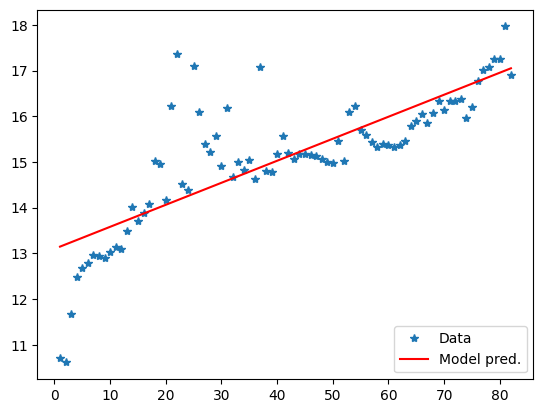

MSE=0.780753685707033
MAE=0.5902180254592803
R2=0.6250280238213579


In [5]:
# Work with number_of_files over time
lr_df = monthly_df.copy()
x = lr_df[["last_modified"]].to_numpy()
y = np.log(lr_df[["number_of_files"]].to_numpy())
N = len(y)
X = np.concatenate([np.ones([N,1]), x], axis=1)
betas = np.linalg.solve(X.T@X,X.T@y)
yHat = X@betas
plt.plot(x,y,'*',label='Data')
plt.plot(x,yHat,'r',label='Model pred.')
plt.legend()
plt.show()
print(f"MSE={((yHat-y)**2).sum()/N}")
print(f"MAE={abs(yHat-y).sum()/N}")
print(f"R2={r2_score(y, yHat)}")

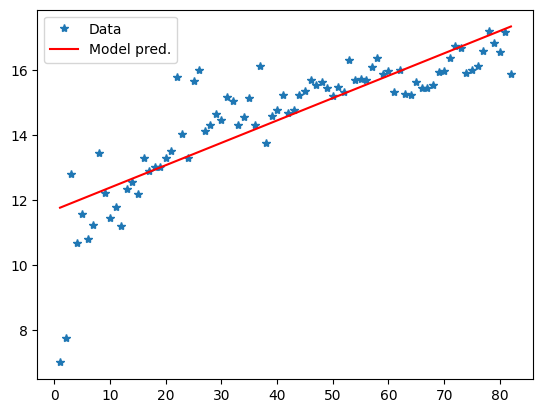

MSE=1.1403761130914676
MAE=0.7155032825960009
R2=0.6997070466860318


In [6]:
# Work with size_mb over time
x = lr_df[["last_modified"]].to_numpy()
y = np.log(lr_df[["size_mb"]].to_numpy())
N = len(y)
X = np.concatenate([np.ones([N,1]), x], axis=1)
betas = np.linalg.solve(X.T@X,X.T@y)
yHat = X@betas
plt.plot(x,y,'*',label='Data')
plt.plot(x,yHat,'r',label='Model pred.')
plt.legend()
plt.show()
print(f"MSE={((yHat-y)**2).sum()/N}")
print(f"MAE={abs(yHat-y).sum()/N}")
print(f"R2={r2_score(y, yHat)}")

### Quadratic regression

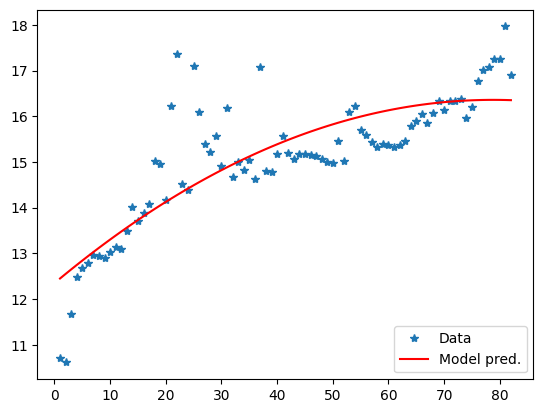

MSE=0.6760116074761207
MAE=0.5796457465105752
R2=0.6753324217157286


In [7]:
# Work with number_of_files over time
qr_df = monthly_df.copy()
x = qr_df[["last_modified"]].to_numpy()
y = np.log(qr_df[["number_of_files"]].to_numpy())
N = len(y)
X = np.concatenate([np.ones([N,1]), x, x**2], axis=1)
betas = np.linalg.solve(X.T@X,X.T@y)
yHat = X@betas
plt.plot(x, y,'*',label='Data')
plt.plot(x, yHat,'r',label='Model pred.')
plt.legend()
plt.show()
print(f"MSE={((yHat-y)**2).sum()/N}")
print(f"MAE={abs(yHat-y).sum()/N}")
print(f"R2={r2_score(y, yHat)}")

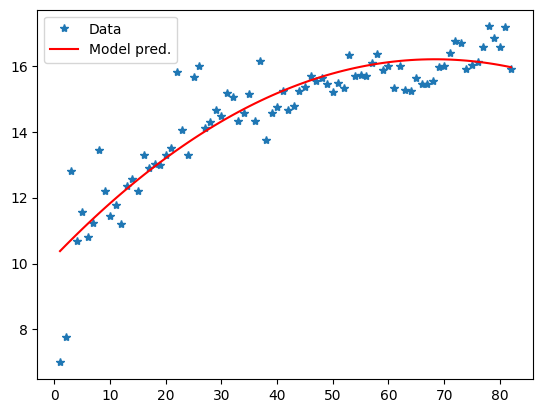

MSE=0.7265330665996294
MAE=0.5658916667099986
R2=0.8086835056041222


In [8]:
# Work with size_mb over time
x = lr_df[["last_modified"]].to_numpy()
y = np.log(lr_df[["size_mb"]].to_numpy())
N = len(y)
X = np.concatenate([np.ones([N,1]), x, x**2], axis=1)
betas = np.linalg.solve(X.T@X,X.T@y)
yHat = X@betas
plt.plot(x, y,'*',label='Data')
plt.plot(x, yHat,'r',label='Model pred.')
plt.legend()
plt.show()
print(f"MSE={((yHat-y)**2).sum()/N}")
print(f"MAE={abs(yHat-y).sum()/N}")
print(f"R2={r2_score(y, yHat)}")

### Cubic regression

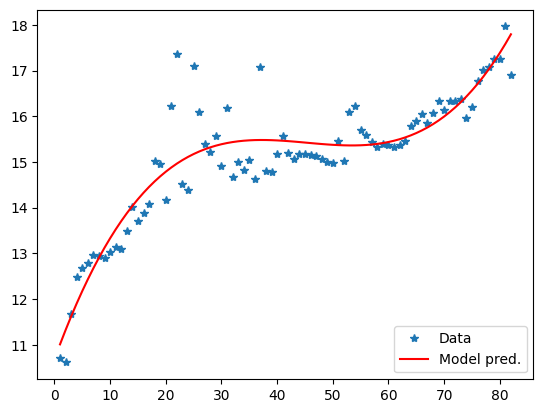

MSE=0.3322237935232269
MAE=0.4154879925652869
R2=0.8404431324865824


In [9]:
# Work with number_of_files over time
lr_df = monthly_df.copy()
x = lr_df[["last_modified"]].to_numpy()
y = np.log(lr_df[["number_of_files"]].to_numpy())
N = len(y)
X = np.concatenate([np.ones([N,1]), x, x**2, x**3], axis=1)
betas = np.linalg.solve(X.T@X,X.T@y)
yHat = X@betas
plt.plot(x,y,'*',label='Data')
plt.plot(x,yHat,'r',label='Model pred.')
plt.legend()
plt.show()
print(f"MSE={((yHat-y)**2).sum()/N}")
print(f"MAE={abs(yHat-y).sum()/N}")
print(f"R2={r2_score(y, yHat)}")

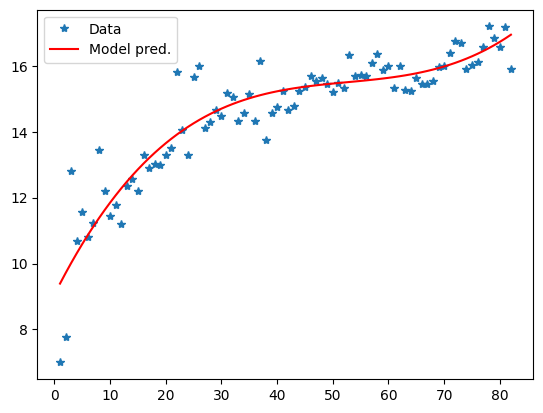

MSE=0.566007372987457
MAE=0.5125978450787405
R2=0.8509544143544758


In [10]:
# Work with number_of_files over time
qr_df = monthly_df.copy()
x = qr_df[["last_modified"]].to_numpy()
y = np.log(qr_df[["size_mb"]].to_numpy())
N = len(y)
X = np.concatenate([np.ones([N,1]), x, x**2, x**3], axis=1)
betas = np.linalg.solve(X.T@X,X.T@y)
yHat = X@betas
plt.plot(x, y,'*',label='Data')
plt.plot(x, yHat,'r',label='Model pred.')
plt.legend()
plt.show()
print(f"MSE={((yHat-y)**2).sum()/N}")
print(f"MAE={abs(yHat-y).sum()/N}")
print(f"R2={r2_score(y, yHat)}")

### Temporary analysis

In [11]:
# Leaving only full years from September '18 until September '24
work_df = pd.read_parquet(gold_file)
work_df["last_modified"] = pd.to_datetime(work_df["last_modified"])
# Filtering out 2024 data
# Perform sum + group by month and bucket
work_df["year"] = work_df.last_modified.dt.year
work_df["month"] = work_df.last_modified.dt.month
groupby_last_modified = work_df.groupby([work_df.month, work_df.year]).sum(["size_mb", "number_of_files"])
monthly_df = groupby_last_modified.reset_index()
monthly_df["last_modified"] = pd.to_datetime(monthly_df[["year", "month"]].assign(day=1))
monthly_df = monthly_df.drop(["month", "year"], axis=1).sort_values("last_modified").rename(columns={"last_modified": "month"}).set_index('month')
before_2024_df = monthly_df[monthly_df.index <= "2023-12-31"]
display(monthly_df)

,size_mb,number_of_files
month,,
2018-01-01,1096.37,44959
2018-02-01,2347.78,40581
2018-03-01,367499.13,117285
2018-04-01,43660.50,263405
2018-05-01,106199.21,317963
...,...,...
2024-06-01,29234233.20,26215166
2024-07-01,20756715.32,31314088
2024-08-01,15528371.47,31179962


<Axes: xlabel='month'>

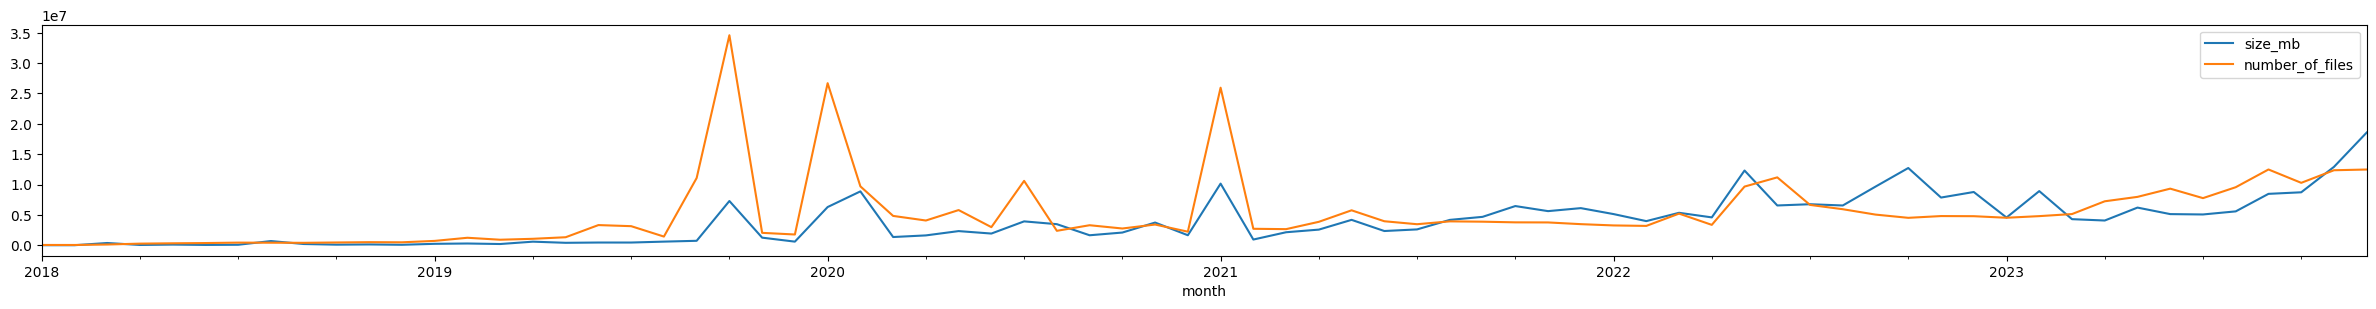

In [12]:
before_2024_df.plot(figsize=(30,3))

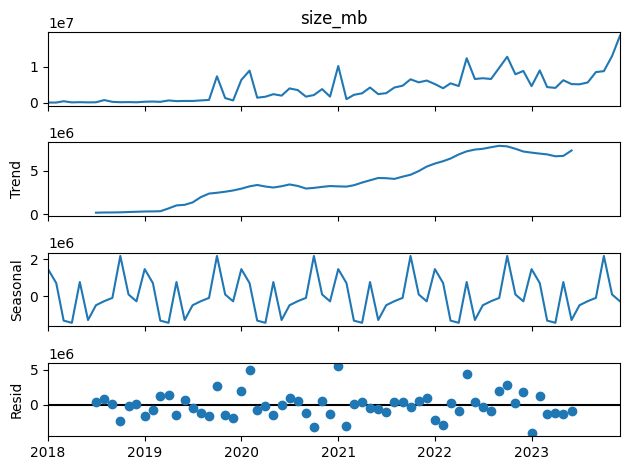

In [13]:
# monthly_df.plot(figsize=(30,3))
size_seasonal_decompose = seasonal_decompose(before_2024_df["size_mb"], model='additive')
size_seasonal_decompose.plot();

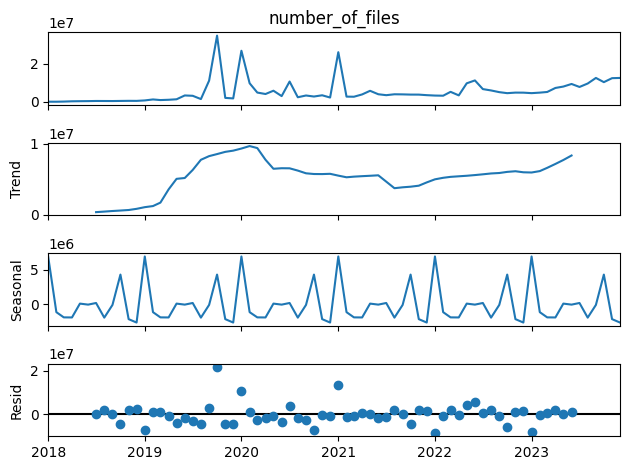

In [14]:
# monthly_df.plot(figsize=(30,3))
filenumber_seasonal_decompose = seasonal_decompose(before_2024_df["number_of_files"], model='additive')
filenumber_seasonal_decompose.plot();

### Forecasting growth for 2024 (analysis vs. real data)

In [19]:
after_2024_df = monthly_df[monthly_df.index > "2023-12-31"]
# display(before_2024_df)
# display(after_2024_df)
fitted_model = ExponentialSmoothing(before_2024_df["number_of_files"], trend="mul", seasonal_periods=12).fit()
test_predictions = fitted_model.predict(10)
# display(test_predictions)

/home/usuario/Diplomado/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/usuario/Diplomado/venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='month'>

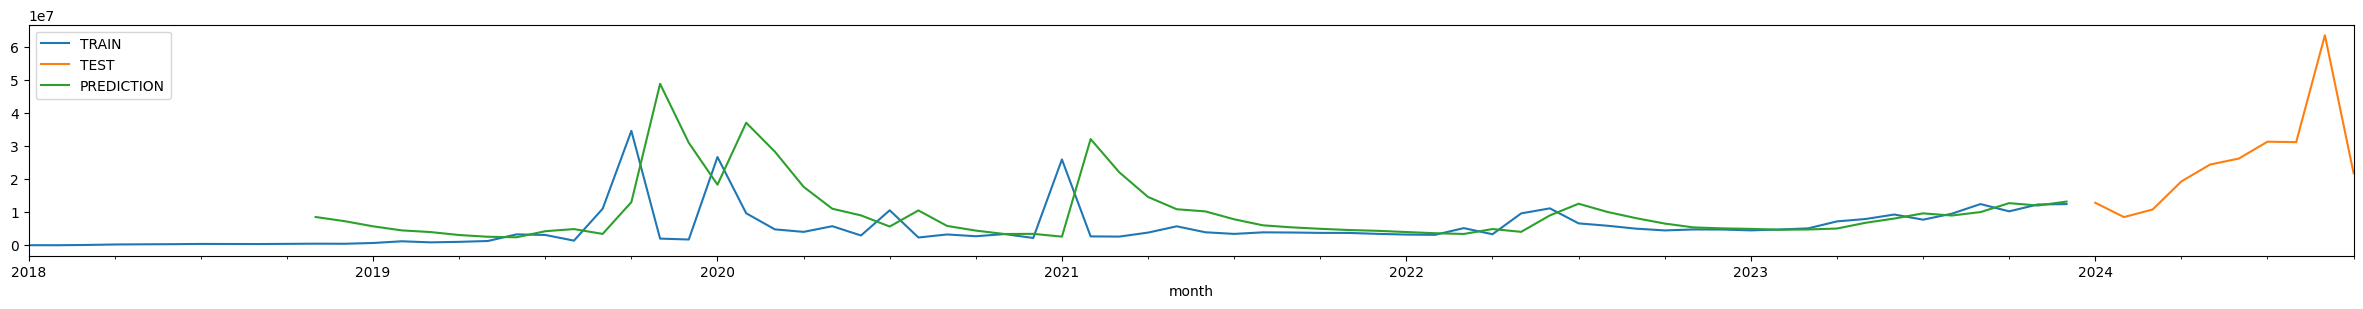

In [20]:
before_2024_df["number_of_files"].plot(legend=True, label="TRAIN")
after_2024_df["number_of_files"].plot(legend=True, label="TEST", figsize=(30,3))
test_predictions.plot(legend=True, label="PREDICTION")

<Axes: xlabel='month'>

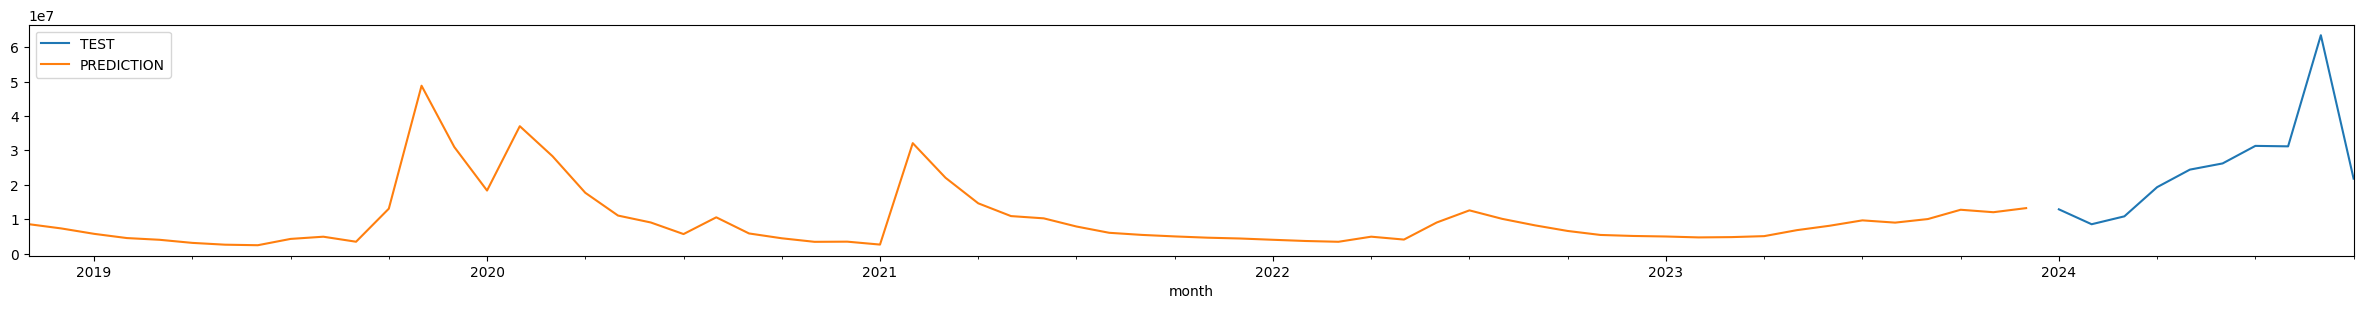

In [21]:
after_2024_df["number_of_files"].plot(legend=True, label='TEST', figsize=(30,3))
test_predictions.plot(legend=True, label="PREDICTION")

### To Do
- Análisis temporal
- Agrupar por meses
- Normalizar las variables Y (hecho: aplicación de np.log)